In [1]:
import pandas as pd

In [101]:
#CSV to df
orders_file = "./Order_data/Cruiser/sales_2019-01-01_2022-08-16.csv"
scooter_df = pd.read_csv(orders_file, keep_default_na=False) #daily order file

### default_na 고쳐야함 --- 데이터 더 필요하기 때문. 근데 일단 cruiser 이런거 찾는데 방해되서 False로 킾

###date range
start_date = '2019-01-01'
end_date = '2022-08-15'
###
mask = (scooter_df['day'] > start_date) & (scooter_df['day'] <= end_date)
scooter_df=  scooter_df.loc[mask]

#sort date
scooter_df['day'] = pd.to_datetime(scooter_df['day'])
scooter_df.sort_values(by='day', inplace = True)

###Select Model  === CRUISER only
cruiser = 'Cruiser' or "CRUISER"
cruiser_df = scooter_df[scooter_df['variant_sku'].str.contains('Cruiser|CRUISER')]
###


#Change Column Names
cruiser_df = cruiser_df.rename({'variant_sku': 'item_id', 'net_quantity': 'y', 'day': 'ds', 
                 'gross_sales': 'price', 'shipping_postal_code': 'location', 'product_vendor': 'brand'}, axis=1) 

#filter out no need data
cruiser_df = cruiser_df.drop(['discounts', 'returns', 'net_sales', 'taxes', 'total_sales'], axis=1)

#Order number greater than 0 - return/cancellation filtering
cruiser_df = cruiser_df[cruiser_df['y'] > 0]

#North America Order filtering
cruiser_df = cruiser_df[(cruiser_df['shipping_country'] == 'United States') | (cruiser_df['shipping_country'] == 'Canada')| (cruiser_df['shipping_country'].isna())]

#color 
black_df = cruiser_df[(cruiser_df['item_id'] == 'Cruiser-Orange') | (cruiser_df['item_id'] == 'CRUISER-Orange')]
black_df = black_df.groupby(by=['ds','item_id']).sum().groupby(level=[0]).cumsum()
black_df.reset_index(inplace=True)


print(black_df)

###
#more_series_df = scooter_df.drop(['demand', 'location', 'brand'], axis=1)
#meta_df = scooter_df.drop(['demand', 'location', 'timestamp', 'promotion_applied', 'location', 'price' ], axis=1)

# print(timeseries_df)
# print(more_series_df)
# print(meta_df)

            ds         item_id  y    price
0   2019-08-06  CRUISER-Orange  1  1399.00
1   2019-08-12  CRUISER-Orange  1  1399.00
2   2019-08-17  CRUISER-Orange  1  1399.00
3   2019-08-18  CRUISER-Orange  1  1399.00
4   2019-08-27  CRUISER-Orange  1  1399.00
..         ...             ... ..      ...
835 2022-08-10  CRUISER-Orange  3  4519.89
836 2022-08-11  CRUISER-Orange  2  2998.00
837 2022-08-13  CRUISER-Orange  3  4497.00
838 2022-08-14  CRUISER-Orange  1  1499.00
839 2022-08-15  CRUISER-Orange  3  4497.00

[840 rows x 4 columns]


In [102]:
#Seasonality

#Canada order zipcode
scooter_df.loc[scooter_df['shipping_country'] == 'Canada', 'location'] = '49868'

scooter_df.loc[scooter_df.discounts < 0, 'promotion_applied'] = 1
scooter_df.loc[scooter_df.discounts >= 0, 'promotion_applied'] = 0

scooter_df['promotion_applied'] = scooter_df['promotion_applied'].astype(int)

# timeseries_df = scooter_df.drop(['promotion_applied', 'price', 'brand'], axis=1)
# & (df['B']>0) & (df['C']>0)]
print(scooter_df[(scooter_df['promotion_applied'] == 0)].count()

# for index, i in timeseries_df[['location']].iterrows():
#     idx = timeseries_df['location'].str.find('-')
#     row = i[0]
#     print(idx[index])
#     if idx[index] == -1:
#         timeseries_df.loc[index, 'location'] = row[:-2]
#     else:
#         timeseries_df.loc[index, 'location'] = row[:idx[index]]
#         print(index)
#         timeseries_df.loc[index, 'location'] = row[:-2]

# timeseries_df['location'] = 'US_' + timeseries_df['location'] +'00'


# timeseries_df['location'].str.find('-')


SyntaxError: unexpected EOF while parsing (Temp/ipykernel_38476/1568160767.py, line 29)

In [103]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import os
import itertools
from prophet.diagnostics import performance_metrics
import joblib
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [104]:
##df_final contains input features, demand_df contains full dataset
##Split data in train and test
cruiser_df = black_df
###

train_percentage=80
train_final_index=round(len(cruiser_df)*(train_percentage/100))
cruiser_df_train = cruiser_df[0:train_final_index]
cruiser_df_test = cruiser_df[train_final_index:]
# X_train = 
# y_train = 
y_test = cruiser_df[['y']][train_final_index:]

print(cruiser_df_train)
print(cruiser_df_test)

            ds         item_id  y   price
0   2019-08-06  CRUISER-Orange  1  1399.0
1   2019-08-12  CRUISER-Orange  1  1399.0
2   2019-08-17  CRUISER-Orange  1  1399.0
3   2019-08-18  CRUISER-Orange  1  1399.0
4   2019-08-27  CRUISER-Orange  1  1399.0
..         ...             ... ..     ...
667 2022-01-21  CRUISER-Orange  1  1399.0
668 2022-01-23  CRUISER-Orange  1  1399.0
669 2022-01-24  CRUISER-Orange  1  1399.0
670 2022-01-25  CRUISER-Orange  1  1399.0
671 2022-01-26  CRUISER-Orange  3  4197.0

[672 rows x 4 columns]
            ds         item_id  y    price
672 2022-01-28  CRUISER-Orange  3  4197.00
673 2022-01-29  CRUISER-Orange  1  1399.00
674 2022-01-30  CRUISER-Orange  1  1399.00
675 2022-02-03  CRUISER-Orange  2  2798.00
676 2022-02-04  CRUISER-Orange  3  4197.00
..         ...             ... ..      ...
835 2022-08-10  CRUISER-Orange  3  4519.89
836 2022-08-11  CRUISER-Orange  2  2998.00
837 2022-08-13  CRUISER-Orange  3  4497.00
838 2022-08-14  CRUISER-Orange  1  1499.00

16:17:54 - cmdstanpy - INFO - Chain [1] start processing
16:17:55 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
835,2022-08-10,1.943769,-0.834995,5.308914,1.943769,1.943769,0.283306,0.283306,0.283306,-0.238014,-0.238014,-0.238014,0.521320,0.521320,0.521320,0.0,0.0,0.0,2.227075
836,2022-08-11,1.941526,-0.728314,5.483098,1.941526,1.941526,0.262046,0.262046,0.262046,-0.305073,-0.305073,-0.305073,0.567119,0.567119,0.567119,0.0,0.0,0.0,2.203572
837,2022-08-13,1.937040,-0.718132,5.715203,1.937040,1.937040,0.407192,0.407192,0.407192,-0.214649,-0.214649,-0.214649,0.621841,0.621841,0.621841,0.0,0.0,0.0,2.344232
838,2022-08-14,1.934797,-0.754897,5.780059,1.934797,1.934797,0.483966,0.483966,0.483966,-0.145152,-0.145152,-0.145152,0.629118,0.629118,0.629118,0.0,0.0,0.0,2.418763
839,2022-08-15,1.932554,-0.852137,5.975300,1.932554,1.932554,0.524795,0.524795,0.524795,-0.097690,-0.097690,-0.097690,0.622485,0.622485,0.622485,0.0,0.0,0.0,2.457349


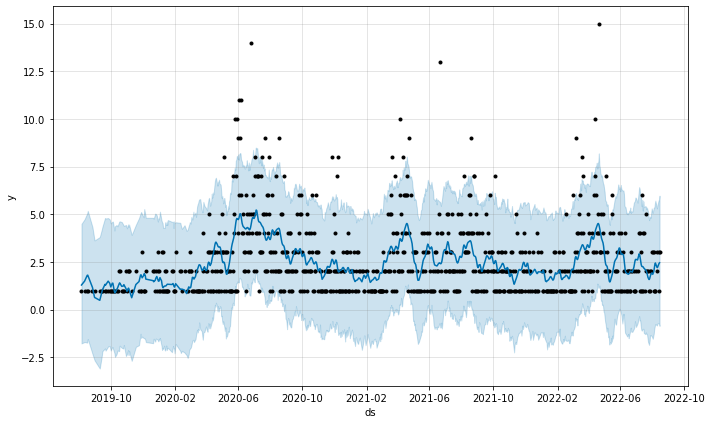

In [105]:
model = Prophet(changepoint_prior_scale= 1, seasonality_prior_scale=5., holidays_prior_scale= 0.01, 
        yearly_seasonality=True, 
        weekly_seasonality= False,
        daily_seasonality=False, 
        interval_width=0.95)
model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
    )

# model.fit(cruiser_df_train)
# prediction = model.predict(cruiser_df_test)

model.fit(cruiser_df)
prediction = model.predict(cruiser_df)

# with open('fb_target_model.json', 'w') as fout:
#     json.dump(model_to_json(model), fout)df_future
    
# Plot error metrics
# print('Root Mean Squared Error:', np.sqrt(mean_squared_error(np.sum(y_test[-7:]), np.sum(prediction['yhat'][-7:]))))
# print('R2 score - ', r2_score(y_test[-7:], prediction['yhat'][-7:]))
model.plot(prediction)

prediction.tail()





In [ ]:
# seasonality regressor
# https://nbviewer.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

In [88]:
#save as CSV file

import os  
os.makedirs('./Order_data/Cruiser/', exist_ok=True) 
prediction.to_csv('./Order_data/Cruiser/prediction.csv', index=False) 
cruiser_df.to_csv('./Order_data/Cruiser/cruiser_df.csv', index=False) 


PermissionError: [Errno 13] Permission denied: './Order_data/Cruiser/prediction.csv'

In [89]:
cruiser_df.to_csv('./Order_data/Cruiser/cruiser_df.csv', index=False) 

ValueError: invalid literal for int() with base 10: 'Date'

In [3]:
#save as CSV file

import os  
os.makedirs('./Order_data/Cruiser/', exist_ok=True) 


timeseries_df.to_csv('./Order_data/Cruiser/timeseries_df.csv', index=False) 
more_series_df.to_csv('./Order_data/Cruiser/more_series_df.csv', index=False) 
meta_df.to_csv('./Order_data/Cruiser/meta_df.csv', index=False) 
